In [1]:
import scipy.io.wavfile
import matplotlib.pyplot as plt
import numpy as np

In [2]:
wave0 = scipy.io.wavfile.read('test.wav')

In [3]:
# sampling frequency
SF = wave0[0]
print("Sampling Frequency :", SF)

# Number of samples
N = wave0[1].size
print("Number of Samples  :", N)

# frequency of signal
f0 = SF/N
print("Frequency of Signal:", f0)

Sampling Frequency : 16000
Number of Samples  : 64000
Frequency of Signal: 0.25


In [4]:
# time interval 
t = np.linspace(0, (N-1)/SF, N)

# frequency sampling
f = np.linspace(0, (N-1)*f0, N)

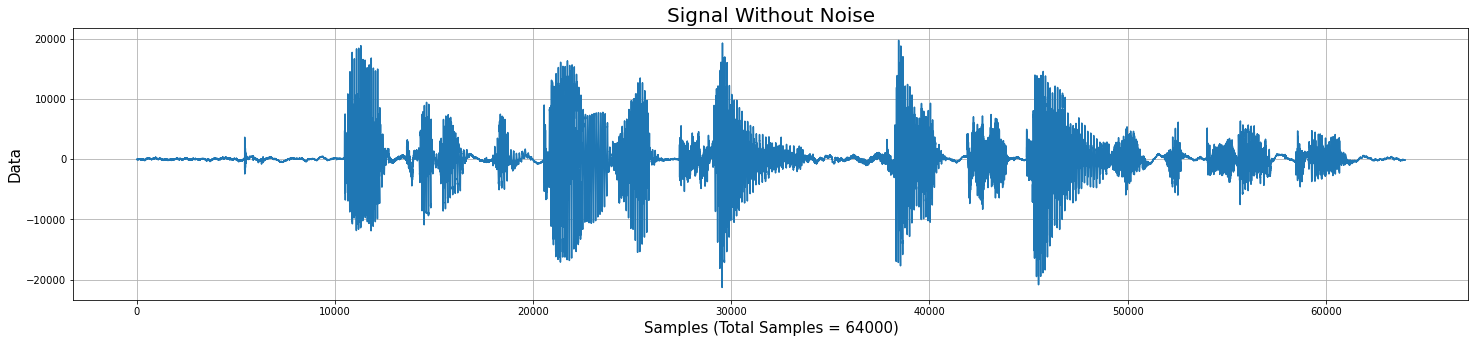

In [5]:
plt.figure(figsize=(25, 5))
plt.plot(wave0[1])
plt.title('Signal Without Noise', fontsize=20)
plt.xlabel(f'Samples (Total Samples = {wave0[1].size})', fontsize=15)
plt.ylabel('Data', fontsize=15)
plt.grid(True)
plt.show()

In [6]:
wave = scipy.io.wavfile.read('test_noise.wav')

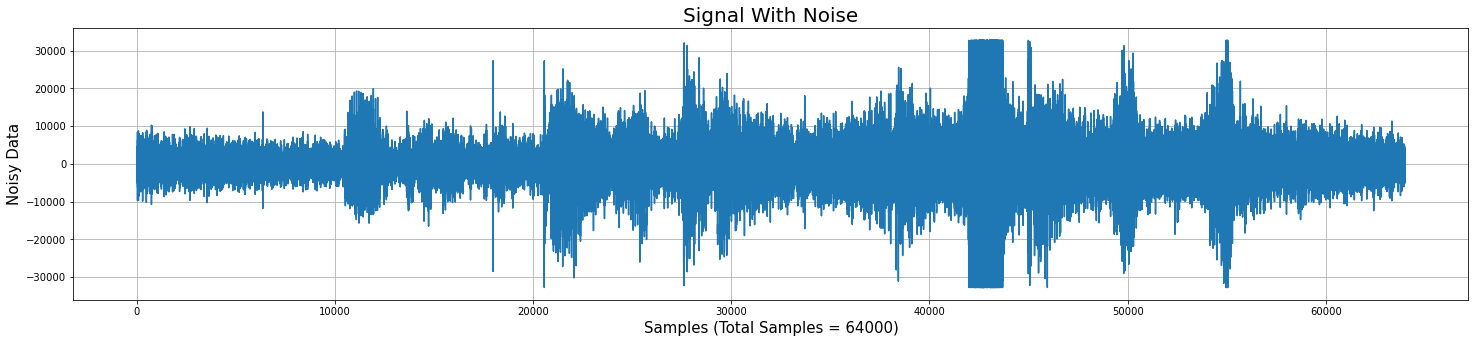

In [7]:
plt.figure(figsize=(25, 5))
plt.plot(wave[1])
plt.title('Signal With Noise', fontsize=20)
plt.xlabel(f'Samples (Total Samples = {wave[1].size})', fontsize=15)
plt.ylabel('Noisy Data', fontsize=15)
plt.grid(True)
plt.show()

## Time Domain Filtering

In [8]:
## filtering window
def w(k):
    return [1/(2*k + 1) for i in range(-k,k+1)]

In [9]:
## Time filtering using the moving average
N = len(wave[1])
def time_filter(k, N):
    this = wave[1].copy()
    f = w(k)
    for n in range(k, N-k):
        avg = 0
        for i in range(n-k, n+k+1):
            avg += wave[1][i]*f[i-(n-k)]
        this[n] = avg
    return this

In [10]:
new_wave = time_filter(5, N)/15000
new_wave = 20000*new_wave

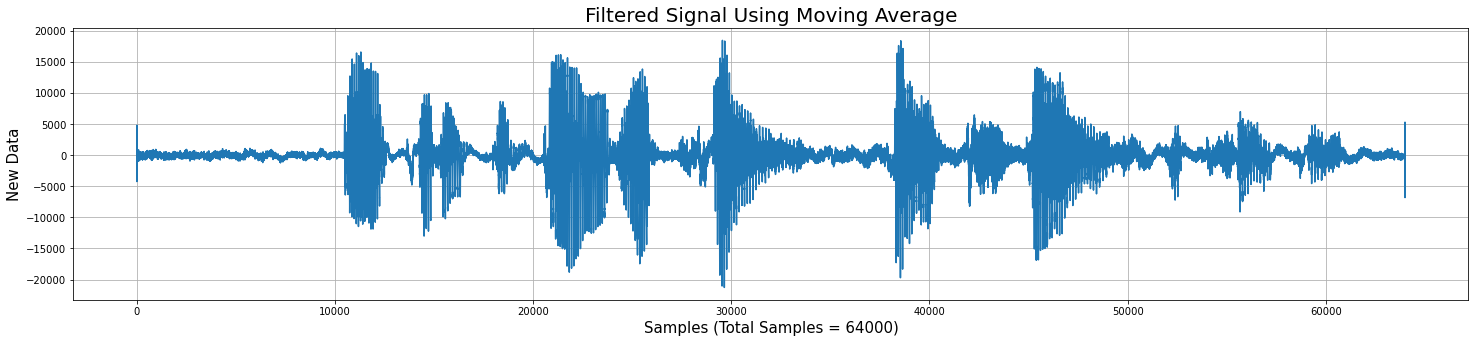

In [11]:
plt.figure(figsize=(25, 5))
plt.plot(new_wave)
plt.title('Filtered Signal Using Moving Average', fontsize=20)
plt.xlabel(f'Samples (Total Samples = {wave[1].size})', fontsize=15)
plt.ylabel('New Data', fontsize=15)
plt.grid(True)
plt.show()

In [12]:
scipy.io.wavfile.write("Time_Filter.wav", wave[0], new_wave.astype('int16'))

## Frequency Domain Filtering

In [13]:
def freq_plot(w, freq, st=''):
    X = np.fft.rfft(w)
    X_mod = np.abs(X)/N # Amplitude
    
    # x and y axes for plot
    x = freq[0:N//2]
    y = 2*X_mod[0:N//2]
    y[0] = y[0]/2

    plt.figure(figsize=(25, 5))
    plt.plot(x, y)
    plt.title(str('Fourier Transform of the Signal ' + st), fontsize=20)
    plt.xlabel('Sampling Frequencies', fontsize=15)
    plt.ylabel('|X(w)| Amplitude', fontsize=15)
    plt.grid(True)
    plt.show()
    return X

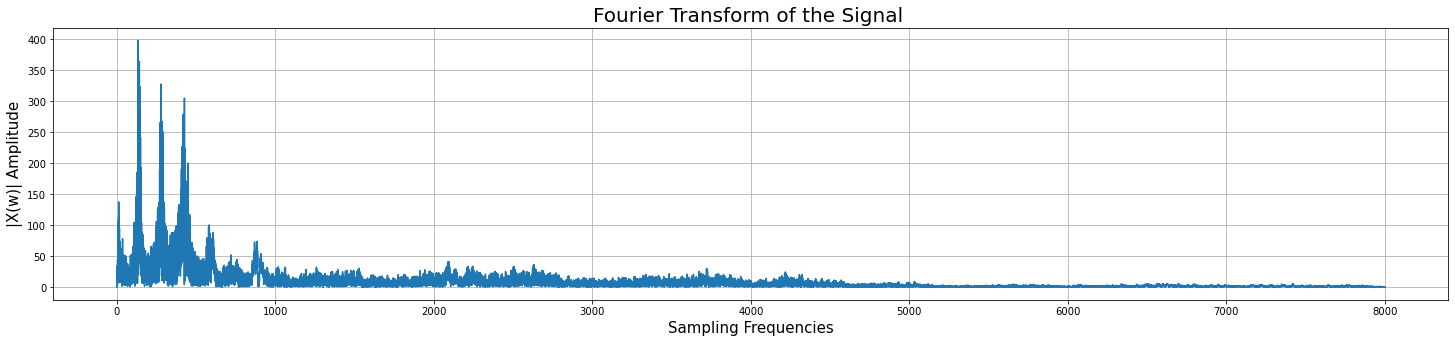

In [14]:
X = freq_plot(wave0[1], f)

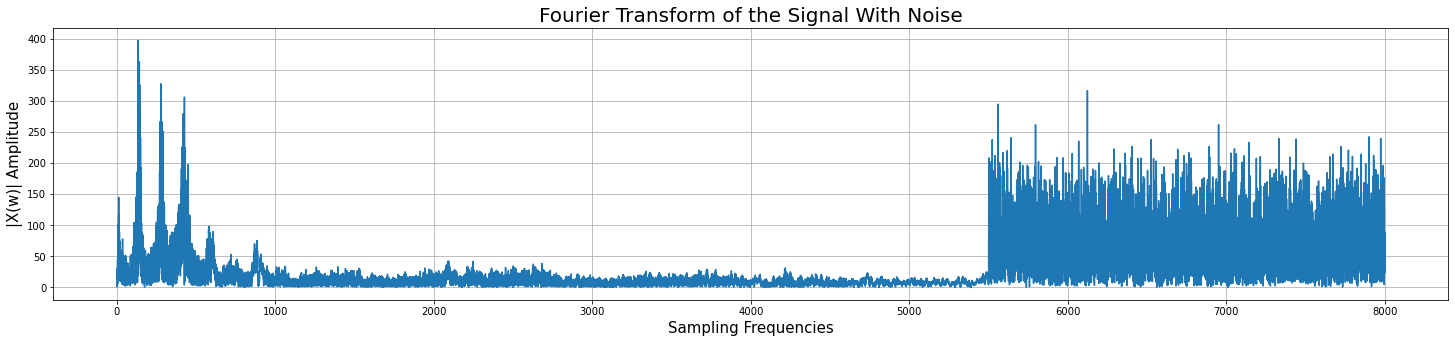

In [15]:
X = freq_plot(wave[1], f, 'With Noise')

In [16]:
## low-pass filtering and choosing the optimal cut-off frequency
X[16000:len(X)] = 0

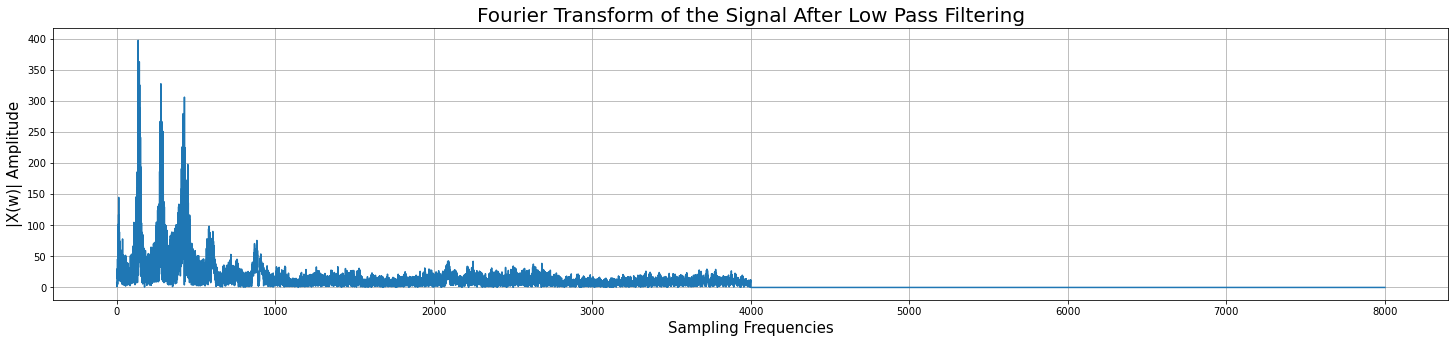

In [17]:
new = np.fft.irfft(X)
X_new = freq_plot(new, f, 'After Low Pass Filtering')

In [18]:
scipy.io.wavfile.write("Frequnecy_Filter.wav", wave[0], new.astype('int16'))

## Spectral Substraction

In [43]:
len_frame = int(SF*f0/2)
tot_frames = N//len_frame

In [44]:
si = wave[1].reshape(tot_frames, len_frame)
h = np.hamming(len_frame)

In [45]:
Si = np.fft.rfft(si*h)

In [46]:
Mi = np.abs(Si)

In [47]:
thetai = np.angle(Si)

In [48]:
noise = np.array([wave[1][i:(i+len_frame)] for i in range(0, 4*len_frame, len_frame)])
noise = np.sum(noise, axis=0)/4
Ni = np.abs(np.fft.rfft(noise))

In [49]:
Mi_hat = Mi.copy()
for i in range(Mi.shape[0]):
    Mi_hat[i] = Mi[i] - Ni
    Mi_hat[i][Mi_hat[i] < 0] = 0

In [50]:
Si_hat = np.multiply(Mi_hat, np.exp(1j*thetai))

In [51]:
estimate = np.fft.irfft(Si_hat)

In [52]:
temp = estimate.reshape(N) 

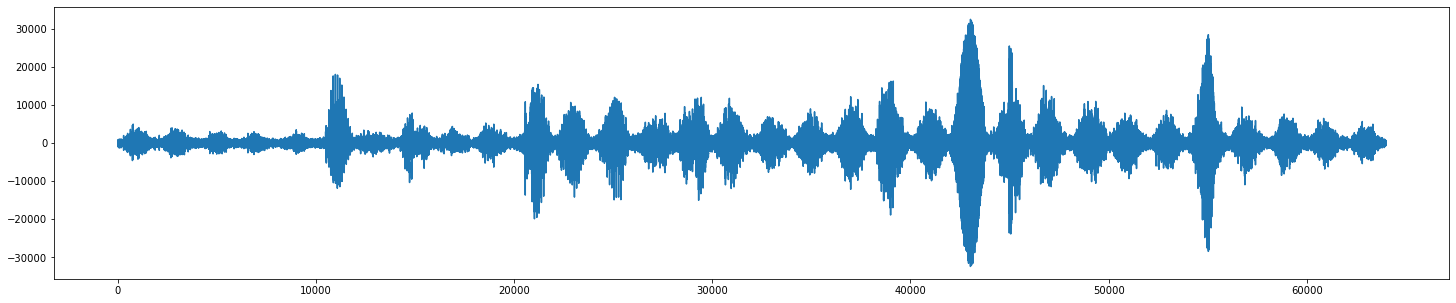

In [53]:
plt.figure(figsize=(25, 5))
plt.plot(temp)

In [54]:
scipy.io.wavfile.write("Spectral_substraction.wav", wave[0], temp.astype('int16'))